In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable inline plotting
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.9.0


In [4]:
# Define the path to the dataset file
data_path = '../data/quark-gluon_data-set_n139306.hdf5'

# Load the dataset
with h5py.File(data_path, 'r') as f:
    # Load the X_jets data
    X_jets_full = f['X_jets'][:]
    y = f['y'][:]

print(f"X_jets shape: {X_jets_full.shape}")
print(f"y shape: {y.shape}")
print(f"y distribution: {np.unique(y, return_counts=True)}")

# Check the range of values in each channel
for i in range(3):
    channel = X_jets_full[..., i]
    print(f"Channel {i}: min={channel.min():.6f}, max={channel.max():.6f}, mean={channel.mean():.6f}, std={channel.std():.6f}")

X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)
y distribution: (array([0., 1.], dtype=float32), array([69653, 69653]))
Channel 0: min=0.000000, max=756.596252, mean=0.000080, std=0.019025
Channel 1: min=0.000000, max=9.334086, mean=0.000051, std=0.001991
Channel 2: min=0.000000, max=0.432766, mean=0.000031, std=0.000490


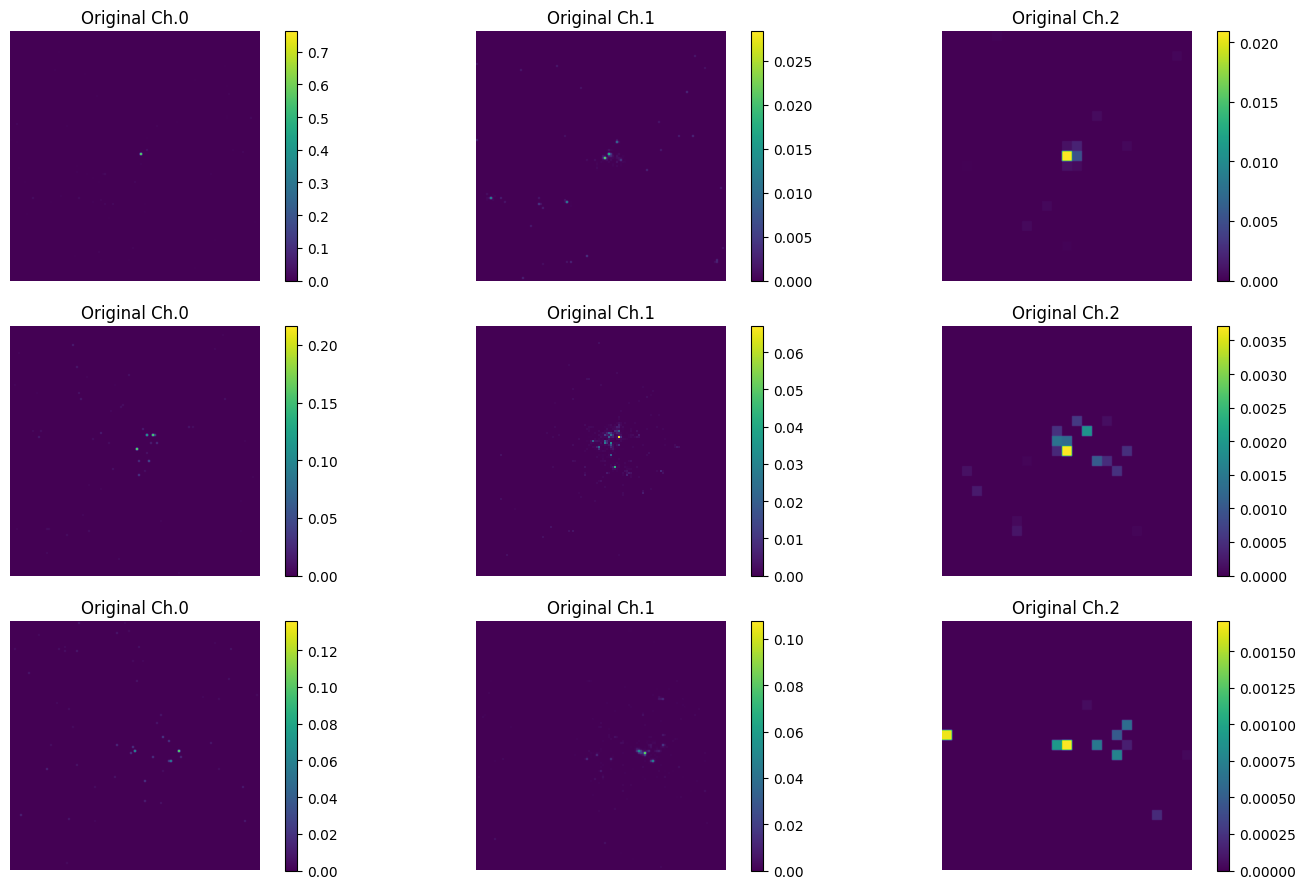

In [5]:
# Function to visualize jet images
def plot_jet_images(images, reconstructed_images=None, n_samples=5):
    fig, axes = plt.subplots(n_samples, 6 if reconstructed_images is not None else 3, figsize=(15, n_samples*3))
    
    # If only one sample, make axes 2D
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_samples):
        idx = np.random.randint(0, len(images))
        image = images[idx]
        
        for j in range(3):
            ax = axes[i, j]
            im = ax.imshow(image[:, :, j], cmap='viridis')
            ax.set_title(f'Original Ch.{j}')
            ax.axis('off')
            plt.colorbar(im, ax=ax)
        
        if reconstructed_images is not None:
            recon_image = reconstructed_images[idx]
            for j in range(3):
                ax = axes[i, j+3]
                im = ax.imshow(recon_image[:, :, j], cmap='viridis')
                ax.set_title(f'Reconstructed Ch.{j}')
                ax.axis('off')
                plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Visualize a few random samples
plot_jet_images(X_jets_full, n_samples=3)

The images are extremely sparse since most pixels are zero

- Channel 0 (ECAL): Shows a few sparse points with values up to ~0.7
- Channel 1 (HCAL): Similar pattern to Channel 0 but with lower intensity values (~0.025-0.1)
- Channel 2 (Tracks): Shows more structured patterns with multiple active pixels, but still very low intensity values (~0.001-0.02)

I think the images represent energy deposits in different detector components

This extreme sparsity is important for our VAE design.

Channel means: [8.00182147e-05 5.10028765e-05 3.07468756e-05]
Channel stds: [0.01902792 0.00199171 0.00048962]
Training data shape: (32000, 125, 125, 3)
Validation data shape: (8000, 125, 125, 3)


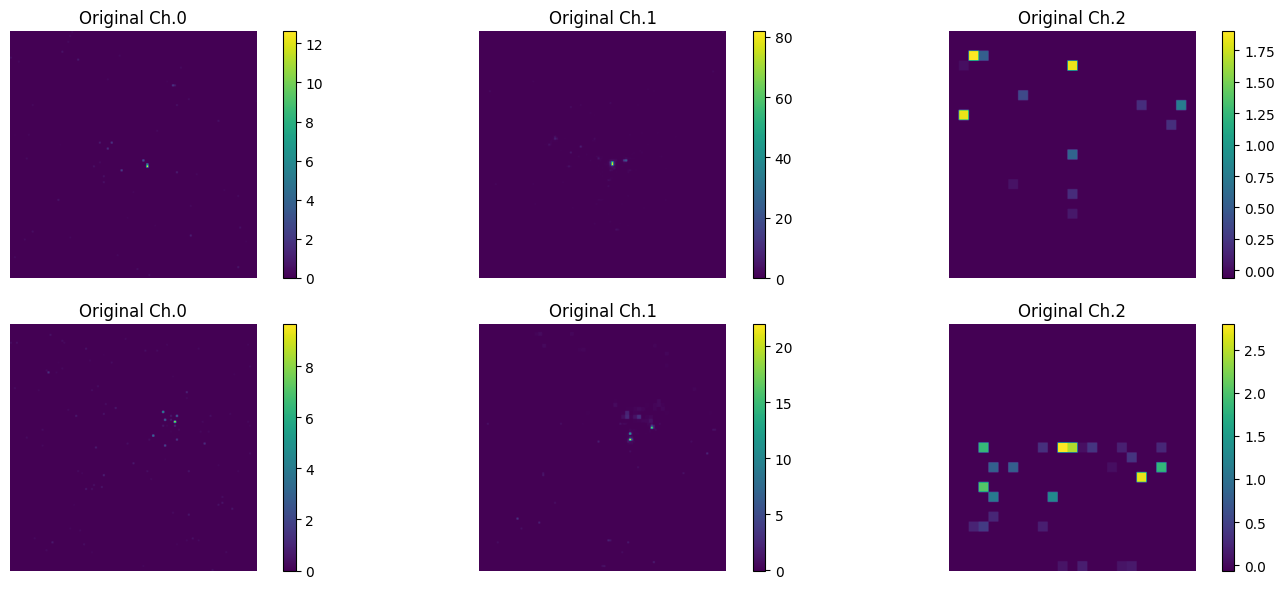

In [6]:
# Normalize the data per channel - optimized for memory usage
def normalize_data_batch(data, batch_size=1000):
    # Get statistics first (mean and std for each channel)
    means = np.zeros(3)
    stds = np.zeros(3)
    
    # Calculate mean and std in batches
    n_samples = len(data)
    n_batches = (n_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # First pass: calculate means
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = data[start_idx:end_idx]
        
        for c in range(3):
            means[c] += np.sum(batch[..., c])
    
    means /= (n_samples * 125 * 125)  # Divide by total number of elements per channel
    
    # Second pass: calculate stds
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = data[start_idx:end_idx]
        
        for c in range(3):
            stds[c] += np.sum((batch[..., c] - means[c])**2)
    
    stds = np.sqrt(stds / (n_samples * 125 * 125))
    # Fix any zero std values
    stds[stds == 0] = 1.0
    
    print("Channel means:", means)
    print("Channel stds:", stds)
    
    # Now create a smaller training and validation set rather than normalizing everything
    # This avoids having to create a full copy of the dataset
    n_samples_to_use = min(40000, n_samples)  # Use a smaller subset
    indices = np.random.permutation(n_samples)[:n_samples_to_use]
    
    # Create normalized subset
    normalized_subset = np.zeros((n_samples_to_use, 125, 125, 3), dtype=np.float32)
    for i in range(n_samples_to_use):
        idx = indices[i]
        for c in range(3):
            normalized_subset[i, :, :, c] = (data[idx, :, :, c] - means[c]) / stds[c]
    
    return normalized_subset, indices

# Split into train (80%) and validation (20%) sets
def train_val_split(data, indices, labels, val_split=0.2):
    n_samples = len(data)
    perm = np.random.permutation(n_samples)
    val_size = int(n_samples * val_split)
    
    val_indices = perm[:val_size]
    train_indices = perm[val_size:]
    
    train_data = data[train_indices]
    val_data = data[val_indices]
    
    # Use the original indices to get the correct labels
    original_train_indices = indices[train_indices]
    original_val_indices = indices[val_indices]
    
    train_labels = labels[original_train_indices]
    val_labels = labels[original_val_indices]
    
    return train_data, val_data, train_labels, val_labels

# Process a smaller subset of the data to avoid memory issues
X_normalized, subset_indices = normalize_data_batch(X_jets_full, batch_size=1000)
X_train, X_val, y_train, y_val = train_val_split(X_normalized, subset_indices, y)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Visualize normalized data
plot_jet_images(X_normalized, n_samples=2)

In [10]:
# Clear any existing models to free memory
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

# Define a smaller VAE architecture
latent_dim = 32  # Reduced from 64

# Encoder - smaller version
def build_encoder_small(input_shape, latent_dim):
    encoder_inputs = keras.Input(shape=input_shape)
    
    # Smaller filters and more aggressive downsampling
    x = layers.Conv2D(8, 3, activation="relu", strides=4, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu", strides=4, padding="same")(x)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# Decoder - smaller version
def build_decoder_small(latent_dim, output_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # Calculate size after downsampling: 125 -> 32 -> 8 -> 4
    conv_shape = (4, 4, 32)
    
    x = layers.Dense(conv_shape[0] * conv_shape[1] * conv_shape[2], activation="relu")(latent_inputs)
    x = layers.Reshape(conv_shape)(x)
    
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=4, padding="same")(x)
    x = layers.Conv2DTranspose(8, 3, activation="relu", strides=4, padding="same")(x)
    
    # Final layer to get back to original shape
    x = layers.Conv2D(3, 3, activation="linear", padding="same")(x)
    
    # Handle the odd dimensions with cropping
    if x.shape[1] > output_shape[0] or x.shape[2] > output_shape[1]:
        crop_h = (x.shape[1] - output_shape[0]) if x.shape[1] > output_shape[0] else 0
        crop_w = (x.shape[2] - output_shape[1]) if x.shape[2] > output_shape[1] else 0
        top_crop = crop_h // 2
        bottom_crop = crop_h - top_crop
        left_crop = crop_w // 2
        right_crop = crop_w - left_crop
        x = layers.Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)))(x)
    
    decoder = keras.Model(latent_inputs, x, name="decoder")
    return decoder

# Use a simpler approach with a custom model (not subclassing Model)
# Create both encoder and decoder
input_shape = X_train.shape[1:]
encoder = build_encoder_small(input_shape, latent_dim)
decoder = build_decoder_small(latent_dim, input_shape)

# Print model summaries
print("Encoder Summary:")
encoder.summary()
print("\nDecoder Summary:")
decoder.summary()

# Create the full VAE model using the functional API
inputs = keras.Input(shape=input_shape)
z_mean, z_log_var, z = encoder(inputs)
outputs = decoder(z)
vae = keras.Model(inputs, outputs, name="vae")

# Define the VAE loss function
def vae_loss(y_true, y_pred):
    # Reconstruction loss (MSE)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2])
    )
    
    # Get the latent space parameters
    z_mean_tensor = encoder.layers[-3].output
    z_log_var_tensor = encoder.layers[-2].output
    
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var_tensor - tf.square(z_mean_tensor) - tf.exp(z_log_var_tensor), axis=1)
    )
    
    # Scale KL loss
    kl_weight = 0.001
    return reconstruction_loss + kl_weight * kl_loss

# Use a smaller subset of data
def get_training_sample(x_data, y_data, n_samples=5000):
    indices = np.random.choice(len(x_data), n_samples, replace=False)
    return x_data[indices], y_data[indices]

# Create a smaller training set
X_train_small, y_train_small = get_training_sample(X_train, y_train, n_samples=5000)
print(f"Using smaller training set: {X_train_small.shape}")

# Compile the model with the custom loss
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125, 125,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 8) │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 16)  │      1,168 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 32)  │      4,640 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,024 (168.06 KB)

 Trainable params: 43,024 (168.06 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 32)       │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 8)    │         1,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           219 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 125, 125, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,147 (125.57 KB)

 Trainable params: 32,147 (125.57 KB)

 Non-trainable params: 0 (0.00 B)

Using smaller training set: (5000, 125, 125, 3)


Epoch 1/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8147
Epoch 1: loss improved from inf to 0.75773, saving model to ../models/vae_best_model.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.8144 - val_loss: 46.1763
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7644
Epoch 2: loss improved from 0.75773 to 0.72221, saving model to ../models/vae_best_model.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.7643 - val_loss: 0.5963
Epoch 3/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7585
Epoch 3: loss improved from 0.72221 to 0.71896, saving model to ../models/vae_best_model.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.7583 - val_loss: 0.5954
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7575
Epoch 4: loss improved from 0.71896 to 0.71822, saving model to ../models/vae_best_model.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.7574 - val_loss: 0.5949
Epoch 5/15
312/313 ━━━━

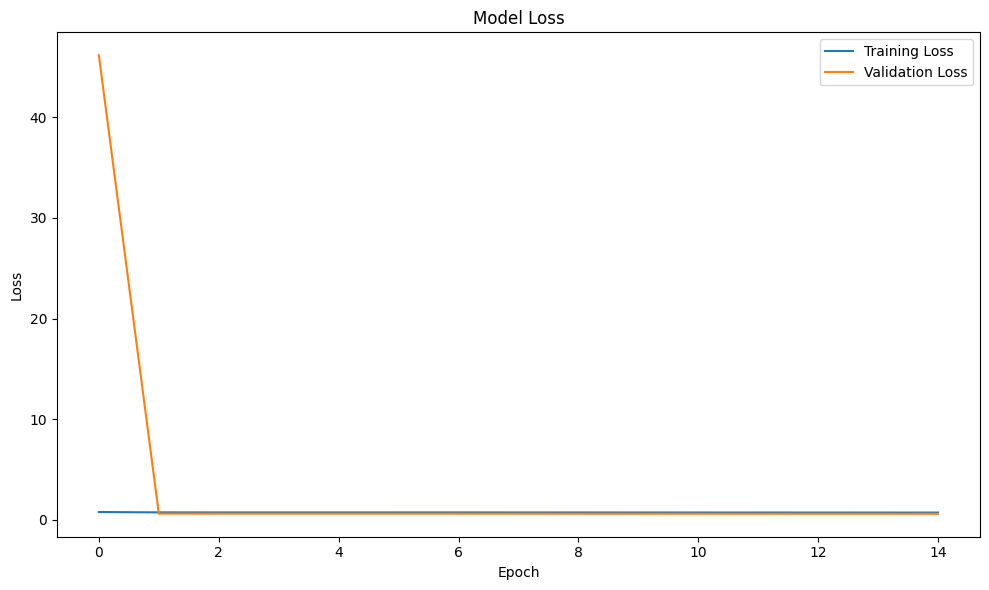

In [11]:
# Create directories for saving model and results
import os
os.makedirs("../models", exist_ok=True)
os.makedirs("../results", exist_ok=True)

# Create a callback to save the best model
checkpoint_path = "../models/vae_best_model.weights.h5"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True
)

# Use a tiny batch size
batch_size = 16
epochs = 15

# Train model
history = vae.fit(
    X_train_small, X_train_small,  # Use the same data for input and output
    validation_data=(X_val[:1000], X_val[:1000]),  # Use only a subset of validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, early_stopping]
)

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


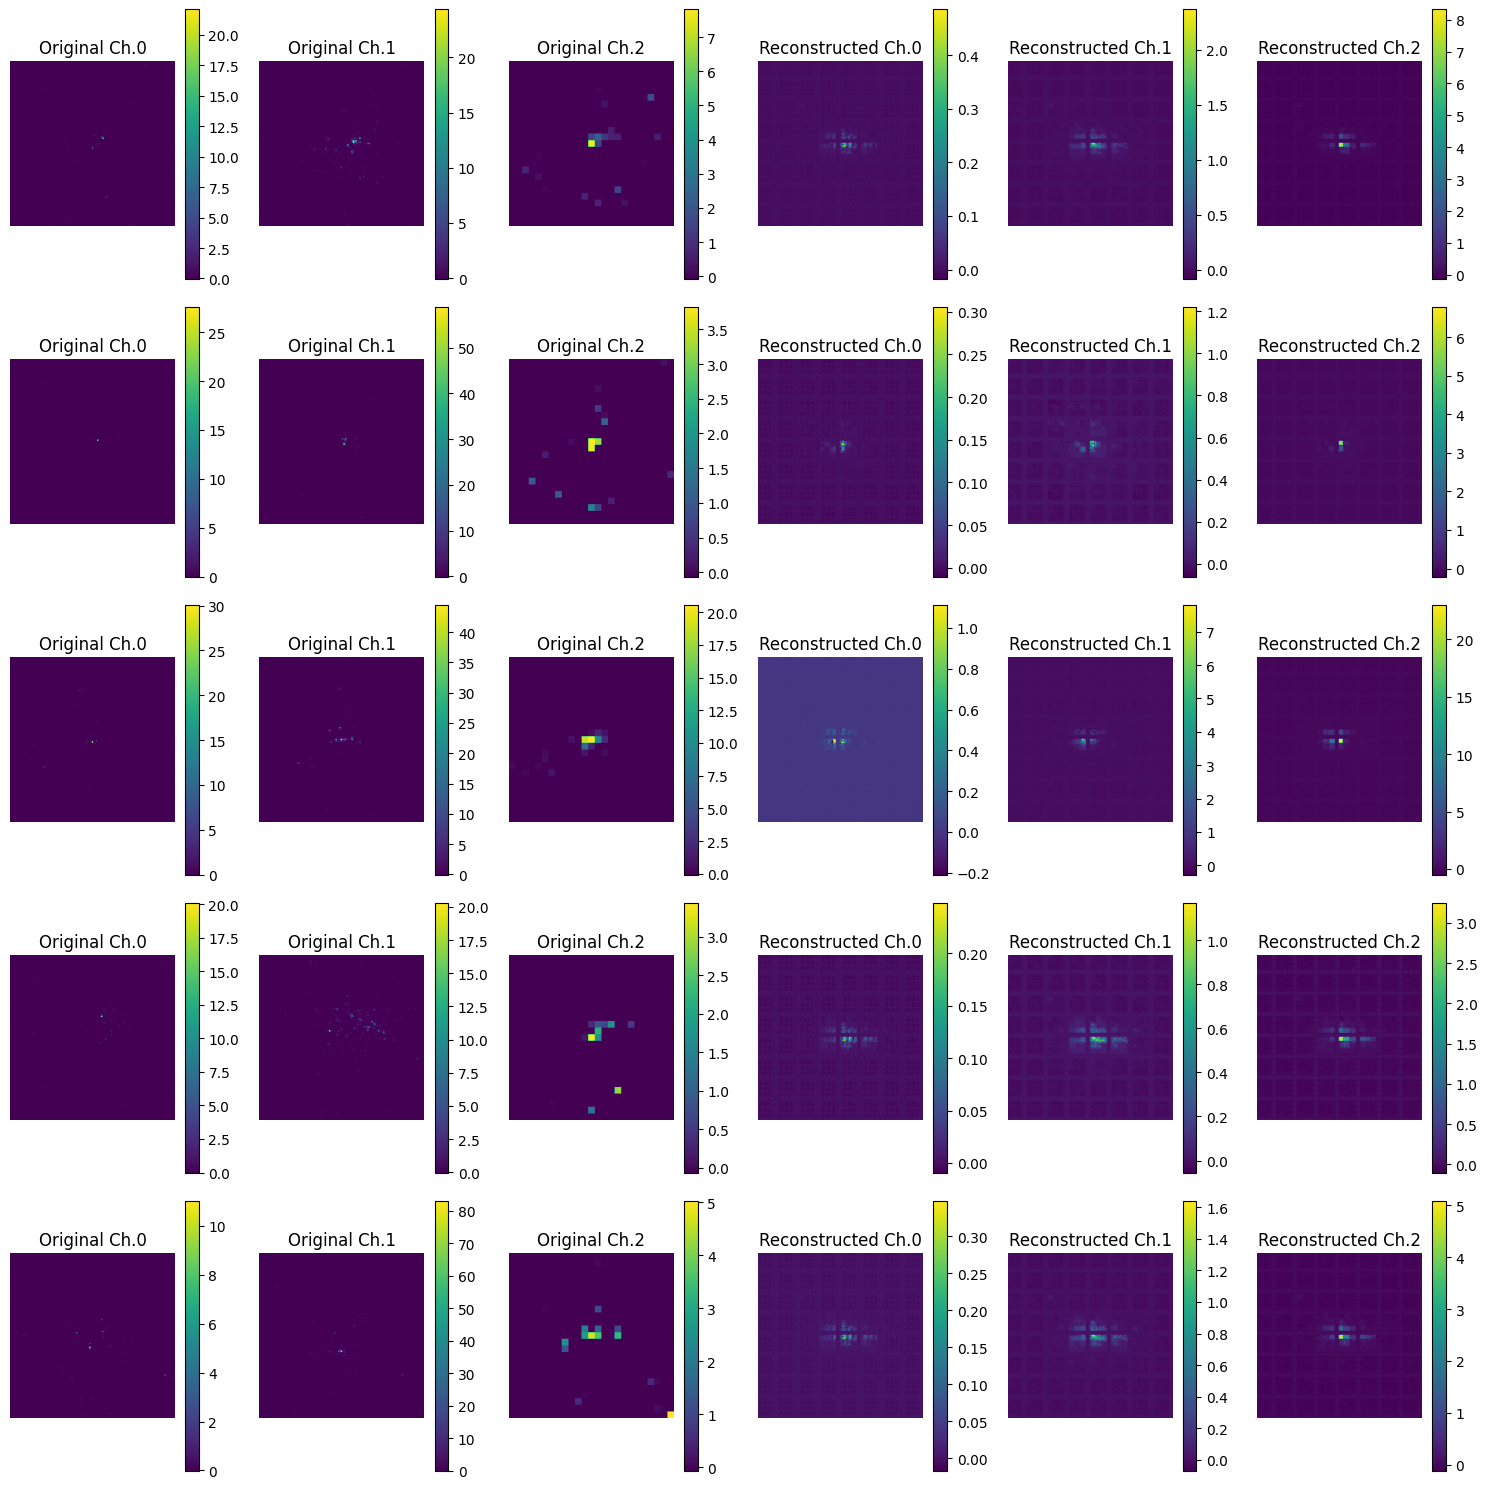

In [12]:
# Generate reconstructions
def generate_and_plot_reconstructions(vae, data, n_samples=5):
    # Select random samples
    indices = np.random.choice(len(data), n_samples, replace=False)
    samples = data[indices]
    
    # Get reconstructions
    reconstructions = vae.predict(samples, batch_size=n_samples)
    
    # Plot original vs reconstruction
    fig, axes = plt.subplots(n_samples, 6, figsize=(15, 3*n_samples))
    
    for i in range(n_samples):
        # Original images
        for j in range(3):
            ax = axes[i, j]
            im = ax.imshow(samples[i, :, :, j], cmap='viridis')
            ax.set_title(f'Original Ch.{j}')
            ax.axis('off')
            plt.colorbar(im, ax=ax)
        
        # Reconstructed images
        for j in range(3):
            ax = axes[i, j+3]
            im = ax.imshow(reconstructions[i, :, :, j], cmap='viridis')
            ax.set_title(f'Reconstructed Ch.{j}')
            ax.axis('off')
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    return samples, reconstructions

# Generate and plot reconstructions
original_samples, reconstructed_samples = generate_and_plot_reconstructions(vae, X_val[:1000], n_samples=5)

In [13]:
# Calculate reconstruction error metrics
def calculate_metrics(originals, reconstructions):
    # Mean squared error per channel
    mse_per_channel = []
    for i in range(3):
        mse = np.mean((originals[..., i] - reconstructions[..., i])**2)
        mse_per_channel.append(mse)
    
    # Overall MSE
    mse_overall = np.mean((originals - reconstructions)**2)
    
    return {
        'mse_channel_0': mse_per_channel[0],
        'mse_channel_1': mse_per_channel[1],
        'mse_channel_2': mse_per_channel[2],
        'mse_overall': mse_overall,
    }

# Calculate metrics
metrics = calculate_metrics(original_samples, reconstructed_samples)

# Print metrics
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

mse_channel_0: 0.040018
mse_channel_1: 0.284911
mse_channel_2: 0.276295
mse_overall: 0.200408


Most points are clustered together on the right side of the plot. There's no clear separation between quark (blue) and gluon (red) jets in the latent space. I think this shows the unsupervised VAE is not naturally discovering features that distinguish between the two classes.
I guess this is expected for an unsupervised VAE.

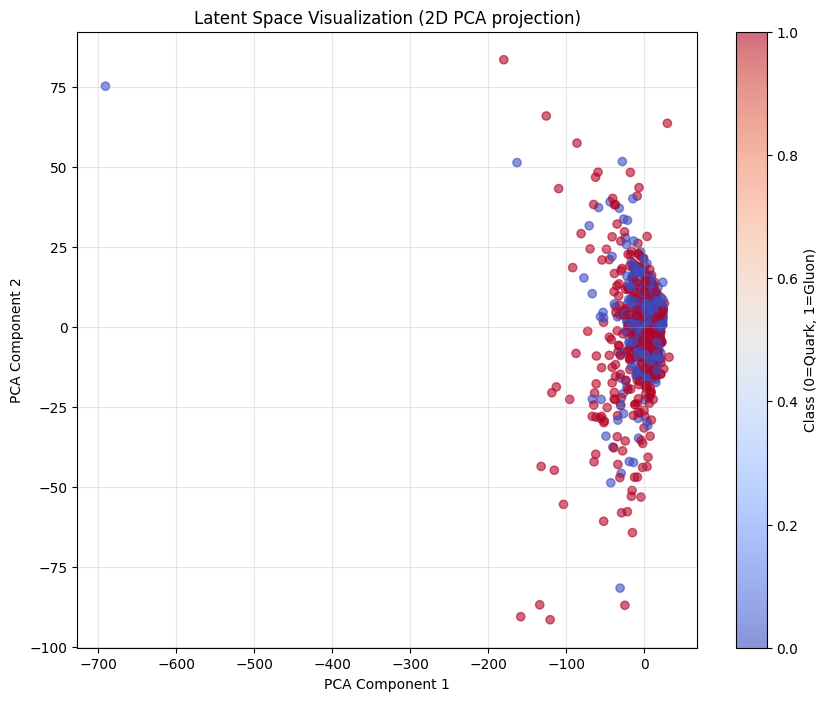

In [14]:
# Encode validation samples
z_mean, z_log_var, z = encoder(X_val[:1000])

# Reduce dimensionality for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z_2d = pca.fit_transform(z.numpy())

# Get corresponding labels for the validation samples
val_labels = y_val[:1000]

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=val_labels, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Class (0=Quark, 1=Gluon)')
plt.title('Latent Space Visualization (2D PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(alpha=0.3)
plt.show()